# Hands-on tutorial of the HADES: Homologous Automated Document Exploration and Summarization
## 

`HADES` is a Python package for comparing similarly structured documents. It is designed to streamline the work of professionals dealing with large volumes of documents, such as policy documents, legal acts, and scientific papers. The tool employs a multi-step pipeline that begins with processing PDF documents using topic modeling, summarization, and analysis of the most important words for each topic. The process concludes with an interactive web app with visualizations that facilitate the comparison of the documents.

## Installation and Imports 

**We recommend using HADES package in the clean environment of Python 3.9**

In order to start using HADES, we need to install the package and download `en_core_web_sm` spacy model which is necessary for text processing.

```
$ pip install -U hades-nlp
$ python -m spacy download en_core_web_sm
```

Next, let's download and unpack sample data to work on. Make sure that you are in a tutorial folder.

```
$ wget 'https://docs.google.com/uc?export=download&id=15L0I1nrvrVcws0qHgFUuYDCwJWeTmUrs' -O resilience_reports.tar.gz
$ tar -zxvf resilience_reports.tar.gz
```

When we have the data prepared, we should import the necessary functions.

In [1]:
from hades.data_loading import load_processed_data
from hades.topic_modeling import ModelOptimizer, save_data_for_app, set_openai_key

If some warning message appears, we can ignore it.

## Data preparation

Before loading the data to Python, we have to set paragraph names of the downloaded documents, that we want to analyse.

In [2]:
PARAGRAPHS = [
    "Executive summary",
    "Recovery and resilience challenges: scene-setter",
    "Objectives, structure and governance of the plan",
    "Summary of the assessment of the plan",
]

Next, we define general stopwords that are often found in documents, but should not be taken into account in further analysis.

In [3]:
STOPWORDS = [
    "austria", "austrian", "belgium", "belgian", "bulgaria", "bulgarian", "czech",
    "cyprus", "cypriot", "germany", "german", "denmark", "danish", "estonia",
    "estonian", "croatia", "croatian", "finland", "finnish", "france", "french",
    "malta", "maltese", "luxembourg", "lithuania", "lithuanian", "latvia", "latvian",
    "italy", "italian", "ireland", "irish", "hungary", "hungarian", "greece",
    "greek", "spain", "spanish", "netherlands", "dutch", "poland", "polish", "portugal",
    "portuguese", "romania", "romanian", "sweden", "swedish", "slovenia", "slovenian",
    "slovakia", "slovak",
]

We proceed to load the data to Python using `load_processed_data`. This function should be used if data is already in the default format. That means that we have prepared a *data.csv* file, which contains at least:
- column with selected sections (here: 'paragraph')
- id_column with a unique identifier of each document (here: 'country')
- text_path column with relative paths to .txt files with paragraphs text content (here: 'text_path')

In [5]:
processed_df = load_processed_data(
    data_path = './resilience_reports/',
    text_path_col = "text_path",
    stop_words = STOPWORDS,
    spacy_model  = "en_core_web_sm",
    processed_filename = "data_processed.joblib",
    data_filename = "data.csv",
    id_column = 'country',
    flattened_by_col = None,
)

Processing data
Processing text


`processed_filename` parameter is useful when we already processed the data. After the first processing, the outcome is saved in *data_processed.joblib* so it can be utilized later.

To understand the usage of the `flattened_by_col` parameter we have to imagine the situation when we are interested in analysing subsections, which are repeated multiple times among many paragraphs. For instance, let's assume that our documents have the following structure:
1. Paragraph about Law 1
    - subsection about positive impacts
    - subsection about negative impacts
2. Paragraph about Law 2
    - subsection about positive impacts
    - subsection about negative impacts
    
If we wanted to compare the subsections about positive impacts with the subsections about negative impacts we would need to add an additional 'subsection' column to *data.csv* and set parameter `flattened_by_col` = 'subsection'. Note that in that case 'text_path' column would contain a path to a .txt file containing the text from a single subsection.

For better model performance you can define more stopwords by analyzing individual paragraphs. The function `plot_counter_lemmas`, which visualizes the most repeated words, can come in handy here.

Instance for "Recovery and resilience challenges: scene-setter" paragraph:

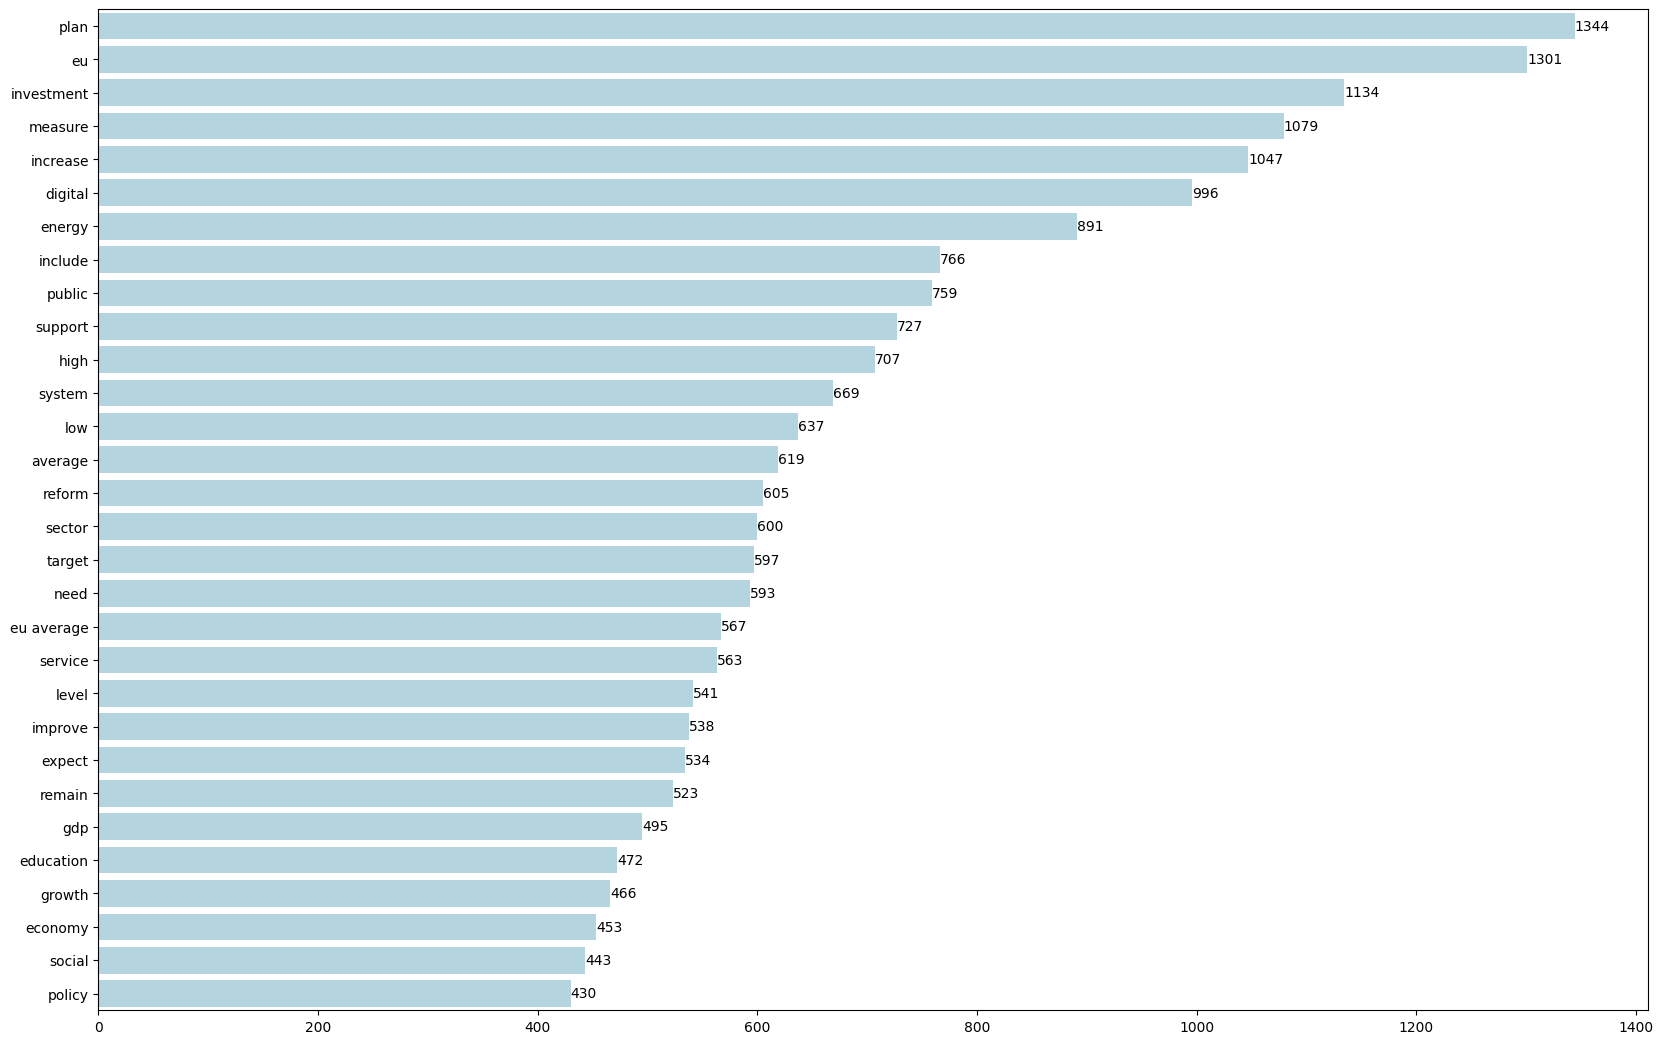

In [6]:
from hades.plots.simple_plots import plot_counter_lemmas

plot_counter_lemmas(processed_df, {'paragraph':'Recovery and resilience challenges: scene-setter'})

In [7]:
PARAGRAPH_STOPWORDS = {
    "Executive summary": ["plan", "measure", "investment", "support", "expect", "reform", "include", "digital"],
    "Recovery and resilience challenges: scene-setter": ["plan", "eu", "investment", "measure", "increase", "digital"],
    "Objectives, structure and governance of the plan": ["plan", "component", "measure", "include", "investment", "support", "reform"],
    "Summary of the assessment of the plan": ["plan", "measure", "investment", "component", "include", "support", "digital", "reform", "expect"],
}

## Creating models

After data preparation, we can start to build our models. The `ModelOptimizer` class is responsible for selecting the optimal models.

In [8]:
model_optimizers = []
for paragraph in PARAGRAPHS:
    model_optimizer = ModelOptimizer(
        df = processed_df,
        id_column = 'country',
        section_column = 'paragraph',
        column_filter = {'paragraph': paragraph},
        model_type = "lda",
        words_to_remove = PARAGRAPH_STOPWORDS[paragraph],
        topic_numbers_range = (3, 6),
        coherence_measure = "c_v",
        coherence_num_words = 20,
        random_state = 42,
        alpha = 100,
    )
    model_optimizers.append(model_optimizer)

100%|██████████| 3/3 [00:11<00:00,  3.91s/it]


Parameters `df`, `id_column`, and `section_column` are self-explanatory. As for the rest:
- `column_filter`-  a dictionary that is used to filter analysed sections.
- `model_type` - model selected to perform topic modelling. If you don't know which one to use, we recommend using "lda" (Latent Dirichlet Allocation) model. If you wish so you can also choose: "nmf" (Non-Negative Matrix Factorization) or "ctm" (Contextualized Topic Models).
- `words_to_remove` - stopwords for individual sections
- `topic_numbers_range` - possible values of numbers of topics that will be evaluated
- `coherence_measure` - coherence measure used to asses topic quality. Possible values are: "u_mass", "c_v", "c_w2v", "c_uci", "c_npmi". For reference check out [this package](https://radimrehurek.com/gensim_3.8.3/models/coherencemodel.html) and [this paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
- `coherence_num_words` - number of words used in coherence evaluation

After those arguments and `random_state` we can (but don't have to) define additional arguments for the choosen model type:
- for LDA: "passes", "iterations", "alpha" ([reference](https://radimrehurek.com/gensim/models/ldamodel.html))
- for NMF: "passes", "kappa" ([reference](https://radimrehurek.com/gensim/models/nmf.html))
- for CTM: "contextualized_model" ([reference](https://pypi.org/project/contextualized-topic-models/))

## Naming topics

If you want to, you can automatically name the topics that models have just created.

In [ ]:
set_openai_key("my openai key")
for model_optimizer in model_optimizers:
    model_optimizer.name_topics_automatically_()

And if you want to, you can correct them manually.

In [9]:
model_optimizers[0].get_topic_names()

0: 0
1: 1
2: 2
3: 3


In [11]:
model_optimizers[0].name_topics_manually(
    topic_names = {
        0: "First topic",
        1: "Second topic",
        2: "Third topic",
        3: "Fourth topic",
    }
)

You can do that by creating a dictionary that takes topic_id's (you can see them when you run the `get_topic_names` method) as keys and new topic names as values.

In a real use case, if you don't want to automatically name the topics you should first analyse the topics' contents in the application and then name the topics respectively.

### Saving data for the app

Finally, when everything is done we can save our models to analyse documents in the web application using the `save_data_for_app` function. At this step, we can also decide to create summaries of each analysed section.

In [12]:
save_data_for_app(model_optimizers, path='results/', do_summaries=False)

### Running the app

To run the app you have to run the following command in the terminal:
```
$ hades run-app --config ./results/config.json
```
Before doing so, make sure that you are in a tutorial folder.